In [1]:
from keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

/home/rajeev/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Load CIFAR-10 dataset

In [2]:
from keras.datasets import cifar10,mnist
from keras.models import Model

(x_train,y_train),(x_test,y_test) = cifar10.load_data()
print("x_train.shape",x_train.shape)
#print("y_train.shape",y_train.shape)
#print("x_test.shape",x_test.shape)
#print("y_test.shape",y_test.shape)

x_train.shape (50000, 32, 32, 3)


In [3]:
x_train = x_train.astype("float32")
#x_train /= 255


### Full VGG16 model

In [4]:
modelFull = VGG16(weights="imagenet")
print("Total layers",len(modelFull.layers))
print(modelFull.summary())

Total layers 23
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

### Partial VGG16 model

In [5]:
modelPartial = VGG16(include_top = False,weights="imagenet")
print("Total layers",len(modelPartial.layers))
print(modelPartial.summary())

Total layers 19
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0    

### Create Visualization model from partial model

In [135]:
# Create dictionaly of layer name and index.
nameToLayer = dict((layer.name,layer) for layer in modelPartial.layers )

finalLayerName = "block3_conv3"

modelInput = modelPartial.input
modelOutput = nameToLayer[finalLayerName].output

# Create model.
model = Model(inputs = modelInput, outputs = modelOutput)
print("Visualization model summary:",model.summary())
print("Visualization model input",model.input)
print("Visualization model output",model.output)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Feed forward:

Input a single image through visualization model to see the output generated from final layer. Output could have multiple dimensions so arrange the dimensions accordingly to check output generated by each filter.

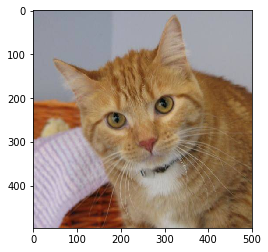

In [136]:
# Take input image from training data.
#inputImgIndex = 4
#inputImg = x_train[inputImgIndex]
#plt.imshow(inputImg.astype("uint8"))

# Load random image from file as input.
import cv2
imgPath = "/home/rajeev/Pictures/cat.194.jpg"
inputImg = cv2.imread(imgPath,cv2.IMREAD_COLOR)
inputImg = cv2.cvtColor(inputImg,cv2.COLOR_BGR2RGB)
inputImg = inputImg.astype("float32")
plt.imshow(inputImg.astype("uint8"))

Prediction shape: (1, 124, 125, 256)


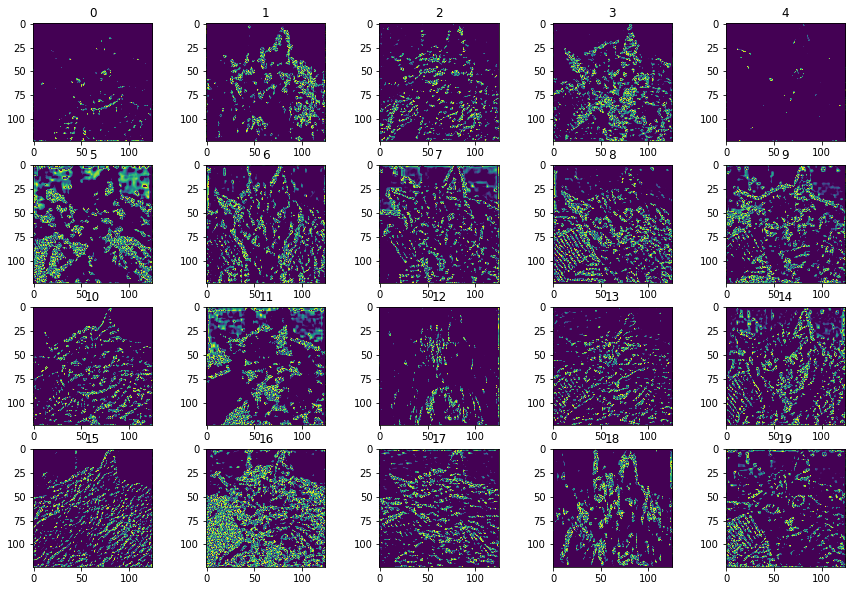

In [138]:
# Generate output of filters from output layer for a given input image.

prediction = model.predict(inputImg[None,:,:,:])
print("Prediction shape:",prediction.shape)

#prediction = prediction[0]
#print("Prediction shape:",prediction.shape)

fig = plt.figure(figsize=(15,10))

for i in range(0,20):
    img = prediction[0,:,:,i]
    #print(img.shape)
    ax = fig.add_subplot(4,5,i+1)
    ax.imshow(img.astype("uint8"))
    ax.set_title(i)

### Create image from noise to maximize output of a particular filter of output

Initially take random noise and pass is through visualization model. Then compute the mean value of output. Create gradients of loss w.r.t input image. As we need to maximize the output of selected filter thus we are doing gradient ascent. So after each forward pass compute loss then compute gradient of loss w.r.t input image and then `add the gradient to image (random noise)` to adapt the image as per selected filter.

In [139]:
# Create pipeline to optimize input noize image to maximize the output of selected filter.



import keras.backend as K
# Create random noise of shape (224,224,3) as this is the shape of input to visualization model.
filterIndex = 10

# Create a loss function. This is the mean value of generated output for selected filter.
layerOutput = model.layers[len(model.layers)-1].output
#layerOutput = model.output
loss = K.mean(layerOutput[:,:,:,filterIndex])

# Compute gradient of loss w.r.t input image
grads = K.gradients(loss,model.input)[0] # output of function is a list, we fetch first element.

# Normalize gradients
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

# Create a function that takes noise image as input and computes loss and gradients for given input.
optimizationFunction = K.function(inputs=[model.input], outputs=[loss,grads])



Noise Image shape (1, 497, 500, 3)


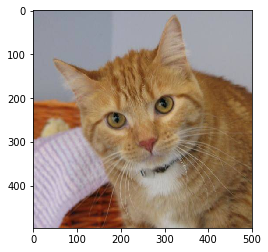

In [149]:
# Create noise image.
#inputImg = np.random.random(size = (1,500,500,3))
#inputImg = (inputImg - 0.5) * 20 + 128
#noiseImg = inputImg.copy()

# Take training data image as input.
#inputImg = x_train[12]
#noiseImg = inputImg.copy()
#noiseImg = noiseImg[None,:,:,:]

# Load random image from file as input.
import cv2
imgPath = "/home/rajeev/Pictures/cat.194.jpg"
inputImg = cv2.imread(imgPath,cv2.IMREAD_COLOR)
inputImg = cv2.cvtColor(inputImg,cv2.COLOR_BGR2RGB)
inputImg = inputImg[None,:,:,:]
inputImg = inputImg.astype("float32")
noiseImg = inputImg.copy()

print("Noise Image shape",noiseImg.shape)
plt.imshow(noiseImg[0].astype("uint8"))
plt.show()

In [150]:


# Now start from noise image and iterate for few iterations. In each iteration compute loss and gradient.
# Update noise image by adding gradients to noise image and re-feed it to network to again compute loss and gradient.
epochs = 30
alpha = 2.0
losses = []
gradsList = []
timeline=[]
for i in range(0,epochs):
    loss_value,grads_value = optimizationFunction(inputs = [noiseImg])
    noiseImg += grads_value * alpha
    print("Epoch {}/{} \t Loss:{} \t grads.shape:{}".format(i+1,epochs,loss_value,grads_value.shape))
    losses.append(loss_value)
    gradsList.append(grads_value)
    timeline.append(noiseImg)
    


Epoch 1/30 	 Loss:80.66464233398438 	 grads.shape:(1, 497, 500, 3)
Epoch 2/30 	 Loss:227.5514373779297 	 grads.shape:(1, 497, 500, 3)
Epoch 3/30 	 Loss:369.792236328125 	 grads.shape:(1, 497, 500, 3)
Epoch 4/30 	 Loss:499.53179931640625 	 grads.shape:(1, 497, 500, 3)
Epoch 5/30 	 Loss:621.1435546875 	 grads.shape:(1, 497, 500, 3)
Epoch 6/30 	 Loss:738.2092895507812 	 grads.shape:(1, 497, 500, 3)
Epoch 7/30 	 Loss:852.825439453125 	 grads.shape:(1, 497, 500, 3)
Epoch 8/30 	 Loss:965.9457397460938 	 grads.shape:(1, 497, 500, 3)
Epoch 9/30 	 Loss:1079.4903564453125 	 grads.shape:(1, 497, 500, 3)
Epoch 10/30 	 Loss:1192.938232421875 	 grads.shape:(1, 497, 500, 3)
Epoch 11/30 	 Loss:1307.939453125 	 grads.shape:(1, 497, 500, 3)
Epoch 12/30 	 Loss:1423.760009765625 	 grads.shape:(1, 497, 500, 3)
Epoch 13/30 	 Loss:1540.09228515625 	 grads.shape:(1, 497, 500, 3)
Epoch 14/30 	 Loss:1657.112060546875 	 grads.shape:(1, 497, 500, 3)
Epoch 15/30 	 Loss:1776.0306396484375 	 grads.shape:(1, 497, 500

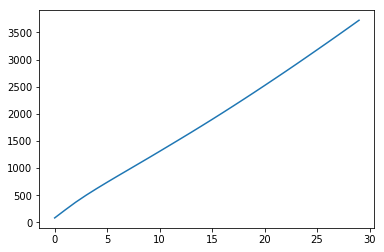

In [151]:
plt.plot(losses)
plt.show()


Original Img shape (1, 497, 500, 3)


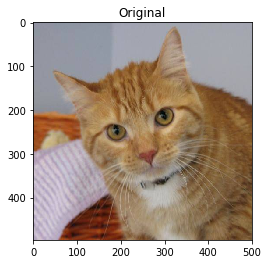

Generated Img shape (1, 497, 500, 3)


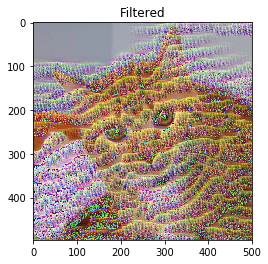

In [152]:
#print(noiseImg)
print("Original Img shape",inputImg.shape)
plt.imshow(inputImg[0].astype("uint8"))
plt.title("Original")
plt.show()

print("Generated Img shape",noiseImg.shape)
plt.imshow(noiseImg[0].astype("uint8"))
plt.title("Filtered")
plt.show()

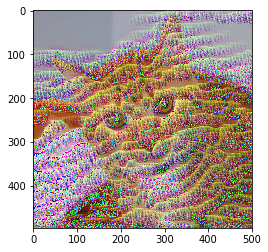

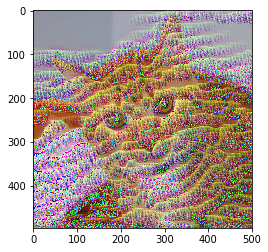

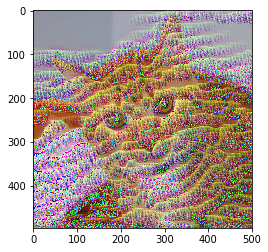

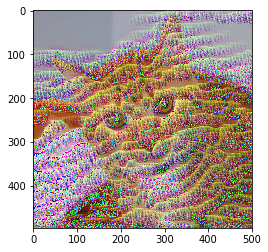

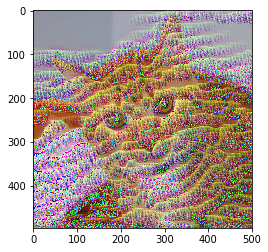

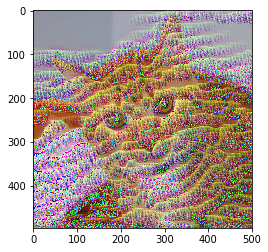

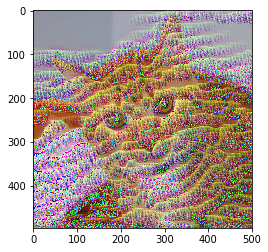

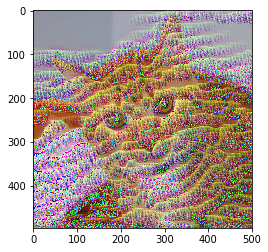

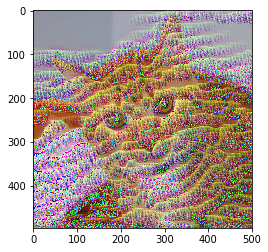

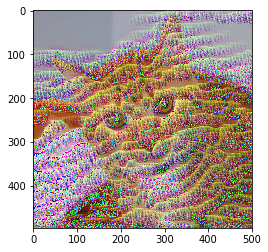

In [154]:
for i in range(0,10):
    plt.imshow(timeline[i][0].astype("uint8"))
    plt.show()